In [1]:
print('')

aim to plot change in gradient as consider changing minimum magntiude of data

In [1]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pickle
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import math

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [2]:
filenames = ['eq_object_03s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_05s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_1s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_4s_bandpass_01_19_snr_20_blank_0_new']

'''filenames = ['eq_object_03s_bandpass_01_19_snr_20_blank_0_new',
              'eq_object_03s_bandpass_01_19_snr_20_blank_005_new',
              'eq_object_03s_bandpass_01_19_snr_20_blank_01_new']

filenames = ['eq_object_05s_bandpass_01_19_snr_20_blank_0_new',
             'eq_object_05s_bandpass_01_19_snr_20_blank_005_new', 
             'eq_object_05s_bandpass_01_19_snr_20_blank_01_new',
             'eq_object_05s_bandpass_01_19_snr_20_blank_025_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_0_new', 
             'eq_object_1s_bandpass_01_19_snr_20_blank_005_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_01_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_025_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_05_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_0_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_005_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_01_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_025_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_05_new']'''

magnitudes = np.arange(3,8, 0.1)

In [3]:
def sort_tp_data(df, mag_lim = 0):
    list_tp_all = list(df.tp_max)
    list_mag_all = list(df.eq_mag)
    list_mag = []
    list_tpmax = []
    count = 0
    for m in range(0, len(list_mag_all)):
        if list_mag_all[m] > mag_lim:
            list_mag.append(list_mag_all[m])
            list_tpmax.append([])
            for d in range(0, len(list_tp_all[m])):
                if list_tp_all[m][d] != None and list_tp_all[m][d]>0:
                    list_tpmax[count].append(list_tp_all[m][d])
            count += 1
    return list_mag, list_tpmax

In [4]:
def plot_tpmax(title, mag_lim, list_mags, list_tpmax):
    params = []
    opacities = np.linspace(0.2,1,45)
    import matplotlib.pyplot as plt
    cs = ['midnightblue']
    #fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    y_aves_tp = []
    x_aves_tp = []
    count = 1
    eq_count = 0
    medians = [[] for _ in range(0, 45)]
    medians_of_medians = [[] for _ in range(0, 45)]
    n = 0
    median_absolute_deviation = []
    sum_absolute_deviation = []
    all_abs_deviation = []
    for n in [1]:#range(1, 10):#number of stations eq at least measured at
        med_for_ad = []
        mag_for_ad = []
        fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
        #for mag_lim in [3.]:#, 3.4, 4.0, 4.4]:#np.arange(3.0, 6.5, 0.1):
        y_aves_tp = []
        x_aves_tp = []
        for i  in range(0, len(list_mags)):
            if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                #if list_mags[i] >= 4 and list_mags[i]<=5:
                if len(list_tpmax[i])>=n:
                    mean_tp = np.mean(list_tpmax[i]) 
                    std_tp = np.std(list_tpmax[i]) 
                    y_tp = [] 
                    for j in list_tpmax[i]: 
                        if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                            y_tp.append(math.log(j, 10))
                        elif len(list_tpmax[i])==1:
                            y_tp.append(math.log(j, 10))
                    x_tp = np.zeros(len(y_tp))  
                    x_tp = x_tp + list_mags[i]
                    c = 0
                    if len(x_tp)>0:
                        if math.isnan(np.median(y_tp))==False:
                            axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 10, c = '#003f5c', marker = 'x', zorder =110, alpha = 0.5)
                    if math.isnan(np.median(y_tp))==False:  
                        y_aves_tp.append(np.median(y_tp))
                        x_aves_tp.append(list_mags[i])
        if len(y_aves_tp)>0:
            x_use = np.array(x_aves_tp) - 5
            y_use = np.array(y_aves_tp)

            print(len(x_aves_tp), len(y_aves_tp))
            count += 1
            x = x_use
            y = y_use
            x_unique = np.arange(-2,3,0.1)
            df_tp = pd.DataFrame(columns = x_unique)

            result = scipy.stats.linregress(x,y)
            a = result.slope
            b = result.intercept
            std_a = result.stderr
            std_b = result.intercept_stderr

            y_1 = (a+std_a)*x_unique + (b+std_b)
            y_2 = (a+std_a)*x_unique + (b-std_b)
            y_3 = (a-std_a)*x_unique + (b+std_b)
            y_4 = (a-std_a)*x_unique + (b-std_b)


            y_min_1sd = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
            y_max_1sd = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))

            y_1 = (a+2*std_a)*x_unique + (b+2*std_b)
            y_2 = (a+2*std_a)*x_unique + (b-2*std_b)
            y_3 = (a-2*std_a)*x_unique + (b+2*std_b)
            y_4 = (a-2*std_a)*x_unique + (b-2*std_b)

            y_min_2sd = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
            y_max_2sd = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))        

            #plt.scatter(x+np.random.uniform(-0.05, 0.05, len(x)),y, marker = 'x', color = 'k', s = 10, alpha = 0.5)
            axs.fill_between(x_unique, y_min_1sd, y_max_1sd, color = '#bc5090', alpha = 0.6, zorder = 100, label = '1sd')
            axs.fill_between(x_unique, y_min_2sd, y_max_2sd, color = '#ffa600', alpha = 0.6, zorder = 99, label = '2sd')
            popt = np.polyfit(x, y, 1)
            axs.plot(x_unique, popt[0]*x_unique+popt[1], color='#003f5c',zorder=102,label='{a:.2f}x+{b:.2f}\npearson r: {r:.4f}'.format(a=result.slope,b=result.intercept-5*result.slope,r=result.rvalue))
            axs.set_ylabel('log10(tpmax)')
            axs.set_xlabel('magnitude')   
            axs.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)
            axs.legend()
            #axs.set_ylim([-2,1])
            t = title.split('_')
            #axs.set_title(f'Predominant period, window = {t[2]}, blanked time = {t[-2][0]}.{t[-2][1:]}s')
            #plt.show()
            #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/all_data/tpmax/{title}/mag{mag_lim:.1f}.pdf', format = 'pdf')
            #plt.close()
            return result.rvalue


In [49]:
gradt, intercept, gradt_std, intercept_std = [],[],[],[]
pearson = []
spearman = []
spearman_p = []

In [47]:
%matplotlib qt 
done = True
if done == True:#for f in filenames:
    f = filenames[1]
    print(f)
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        df = pd.read_pickle(f'/home/earthquakes1/homes/Rebecca/phd/data/results_database/{f}')
        list_mags, list_tpmax = sort_tp_data(df, mag_lim)
        #print(len(list_mags), len(list_tpmax))
        params = []
        opacities = np.linspace(0.2,1,45)
        cs = ['midnightblue']
        #fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
        y_aves_tp = []
        x_aves_tp = []
        count = 1
        eq_count = 0
        medians = [[] for _ in range(0, 45)]
        medians_of_medians = [[] for _ in range(0, 45)]
        n = 0
        median_absolute_deviation = []
        sum_absolute_deviation = []
        all_abs_deviation = []
        for n in [1]:#number of stations eq at least measured at
            med_for_ad = []
            mag_for_ad = []

            y_aves_tp = []
            x_aves_tp = []
            for i  in range(0, len(list_mags)):
                if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                    if len(list_tpmax[i])>=n:
                        mean_tp = np.mean(list_tpmax[i]) 
                        std_tp = np.std(list_tpmax[i]) 
                        y_tp = [] 
                        for j in list_tpmax[i]: 
                            if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                                y_tp.append(math.log(j, 10))
                            elif len(list_tpmax[i])==1:
                                y_tp.append(math.log(j, 10))
                        x_tp = np.zeros(len(y_tp))  
                        x_tp = x_tp + list_mags[i]
                        c = 0
                        #if len(x_tp)>0:
                            #if math.isnan(np.median(y_tp))==False:
                                #axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 10, c = '#003f5c', marker = 'x', zorder =110, alpha = 0.5)
                        if math.isnan(np.median(y_tp))==False:  
                            y_aves_tp.append(np.median(y_tp))
                            x_aves_tp.append(list_mags[i])
            if len(y_aves_tp)>0:
                x_use = np.array(x_aves_tp) - 5
                y_use = np.array(y_aves_tp)

                #print(len(x_aves_tp), len(y_aves_tp))
                count += 1
                x = x_use
                y = y_use
                if mag_lim ==3.:
                    x_all = x
                    y_all = y
                x_unique = np.arange(-2,3,0.1)
                df_tp = pd.DataFrame(columns = x_unique)

                if len(set(x))>1:
                    result = scipy.stats.linregress(x,y)
                    a = result.slope
                    gradt.append(a)
                    b = result.intercept
                    intercept.append(b)
                    std_a = result.stderr
                    gradt_std.append(std_a)
                    std_b = result.intercept_stderr
                    intercept_std.append(std_b)

                    pearson.append(result.rvalue)
                    spearman.append(scipy.stats.spearmanr(x,y)[0])
                    spearman_p.append(scipy.stats.spearmanr(x,y)[1])
                    n_l.append(len(x))
    median, bin_edges, bin_number = scipy.stats.binned_statistic(x_all, y_all, statistic='median', bins=np.arange(-2,3,0.1), range=None)
    fig, axs = plt.subplots(5,1, figsize = (12,9))
    axs[0].plot(magnitudes[0:len(spearman)],gradt)
    axs[0].set_ylabel('gradient')
    axs[1].plot(magnitudes[0:len(spearman)],spearman)
    axs[1].set_ylabel('spearman r')
    axs[2].plot(magnitudes[0:len(spearman)],spearman_p)
    axs[2].set_ylabel('p-value \n of spearman \n (H0=linearly \n uncorrelated)')
    axs[2].axhspan(0, 0.05, facecolor='skyblue', alpha=0.5)
    axs[3].plot(magnitudes[0:len(spearman)],n_l)
    axs[3].set_ylabel('n')
    axs[4].plot(bin_edges[:-1]+5.05, median)
    axs[4].set_ylabel('median')
    axs[0].set_title(f)
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/gradt_spearman/median_{f}.pdf', dpi=400)
    #done = False

eq_object_05s_bandpass_01_19_snr_20_blank_0_new


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._me

In [10]:
median, bin_edges, bin_number = scipy.stats.binned_statistic(x_all+5, y_all, statistic='median', bins=np.arange(3,8,0.1), range=None)

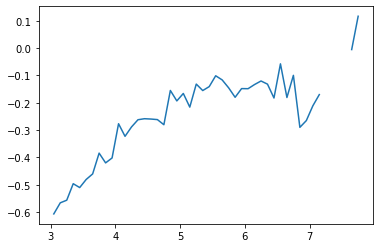

In [12]:
plt.plot(bin_edges[:-1]+0.05, median)

In [21]:
median

array([-0.60710758, -0.56650022, -0.55688406, -0.49649903, -0.51062296,
       -0.48100814, -0.46063565, -0.38450983, -0.42027018, -0.40222142,
       -0.2768585 , -0.32299522, -0.28868837, -0.26226931, -0.2585232 ,
       -0.25972191, -0.2617376 , -0.28052899, -0.15506187, -0.19334685,
       -0.16605858, -0.2160241 , -0.13169541, -0.15541447, -0.14100036,
       -0.10127748, -0.11641139, -0.14538857, -0.18006467, -0.14822382,
       -0.14860251, -0.13338228, -0.12038071, -0.13194822, -0.18268219,
       -0.05758524, -0.18086045, -0.09973914, -0.29013626, -0.26529102,
       -0.21146996, -0.17020924,         nan,         nan,         nan,
               nan, -0.0053678 ,  0.11669354,         nan])

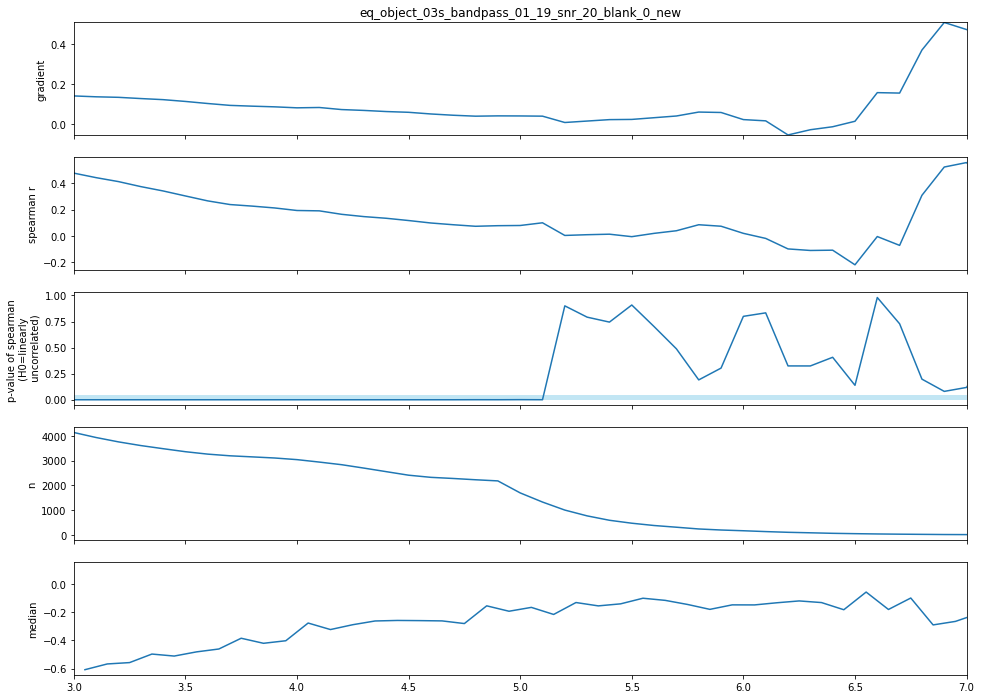

In [37]:
fig, axs = plt.subplots(5,1, figsize = (16,12), sharex = True)
axs[0].plot(magnitudes[0:len(spearman)],gradt)
axs[0].set_ylabel('gradient')
axs[0].set_ylim([min(gradt), max(gradt[:40])])
axs[1].plot(magnitudes[0:len(spearman)],spearman)
axs[1].set_ylabel('spearman r')
axs[2].plot(magnitudes[0:len(spearman)],spearman_p)
axs[2].set_ylabel('p-value of spearman \n (H0=linearly \n uncorrelated)')
axs[3].plot(magnitudes[0:len(spearman)],n_l)
axs[3].set_ylabel('n')
axs[4].plot(bin_edges[:-1]+0.05, median)
axs[4].set_ylabel('median')
axs[2].axhspan(0, 0.05, facecolor='skyblue', alpha=0.5)
axs[0].set_xlim([3,7])
axs[0].set_title(f)
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/gradt_spearman/median_{f}.pdf', dpi=400)

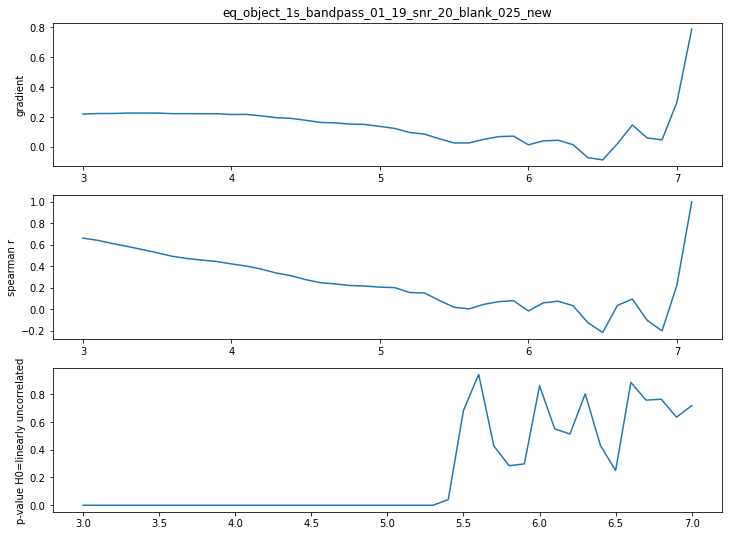

In [25]:
fig, axs = plt.subplots(3,1, figsize = (12,9))
axs[0].plot(magnitudes[0:47],gradt)
axs[0].set_ylabel('gradient')
axs[1].plot(magnitudes[0:47],spearman)
axs[1].set_ylabel('spearman r')
axs[2].plot(magnitudes[0:47],spearman_p)
axs[2].set_ylabel('p-value H0=linearly uncorrelated')
axs[0].set_title(f)
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/gradt_spearman/{f}.pdf', dpi=400)

In [44]:
list_mags

[7.8, 7.8]